# Risk Measures

This notebook illustrates the Value at Risk (VaR) and tests it on a data set. To improve the performance, a model for time-varying risk is estimated and incorporated into the VaR calculations.

## Load Packages and Extra Functions

In [1]:
using Dates, Distributions, DelimitedFiles

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printTable2

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Value at Risk (VaR) for a N(μ,σ²) Return

$\textrm{VaR}_{95\%} = - (5^{th}$ percentile of the return distribution)

With a $N(\mu,\sigma^2)$ distribution this gives

$\textrm{VaR}_{95\%} = - (\mu-1.64\sigma)$

In [3]:
ϕ(x,μ=0,σ²=1) = pdf(Normal(μ,sqrt(σ²)),x)  #lecture note notation for pdf of N(μ,σ²)

ϕ (generic function with 3 methods)

In [4]:
μ = 8
σ = 16

q05   = μ - 1.64*σ 
VaR95 = -(μ - 1.64*σ)
printlnPs("with μ=$μ and σ=$σ, the 5th quantile and VaR 95% are ≈ ",[q05 VaR95])

with μ=8 and σ=16, the 5th quantile and VaR 95% are ≈    -18.240    18.240


In [5]:
q05b = quantile(Normal(μ,σ),0.05)    #exact calculation of the the 5th quantile
printlnPs("get an exact result by using the quantile() function: ",q05b)

get an exact result by using the quantile() function:    -18.318


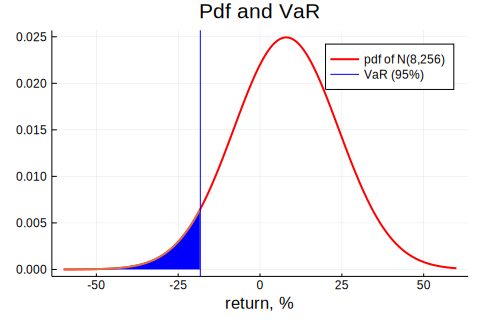

In [6]:
R    = range(-60,stop=60,length=301)
pdfR = ϕ.(R,μ,σ^2)
Rb   = R[R .<= -VaR95]

plot( R,pdfR,
      linecolor = :red,
      linewidth = 2,
      label = "pdf of N($μ,$(σ^2))",
      title = "Pdf and VaR",
      xlabel = "return, %" )

plot!(Rb,ϕ.(Rb,μ,σ^2),fillcolor=:red,linewidth=2,fill=(0,:blue),label="")
vline!([-VaR95],linecolor=:blue,label="VaR (95%)")

# Loading Daily S&P 500 Data

In [7]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = x[:,2]                               #S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1) * 100  #returns, % 
T  = length(R)

dN = Date.(x[2:end,1],"d/m/y")    #convert to Date, 2:end as for R

println("Number of days in the sample: $T")

Number of days in the sample: 9352


# Backtesting a Static VaR from N() on Data

To backtest a VaR model, study the relative frequency of Loss > VaR. 

The code below does this for difference confidence levels (0.95,0.96,...) of the VaR.

In [8]:
μ_emp = mean(R)                             #mean and std of data
σ_emp = std(R)

confLev = 0.95:0.005:0.995
L       = length(confLev)
Loss    = -R

(VaR,BreakFreq) = (fill(NaN,L),fill(NaN,L))
for i = 1:L                 #loop over confidence levels
    VaR[i]       = -quantile(Normal(μ_emp,σ_emp),1-confLev[i])
    BreakFreq[i] = mean(Loss .> VaR[i]) #freq of breaking the VaR
end

printblue("Backtesting a static VaR:")
colNames = ["1-conf level","N()-based VaR","break freq"]
printTable([1.0.-confLev VaR BreakFreq],colNames,fill("",L),width=18)

Backtesting a static VaR:
      1-conf level     N()-based VaR        break freq
             0.050             1.790             0.041
             0.045             1.846             0.037
             0.040             1.907             0.034
             0.035             1.975             0.032
             0.030             2.052             0.029
             0.025             2.140             0.026
             0.020             2.244             0.023
             0.015             2.373             0.019
             0.010             2.547             0.016
             0.005             2.824             0.012



The code below studies the relative frequency of Loss > VaR, but this time over a moving data window. This allows us to investigate if there are long periods of failure (in either direction) the VaR.

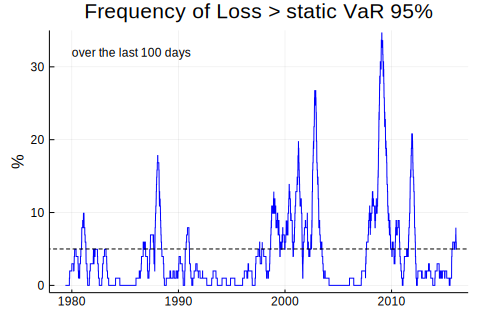

In [9]:
VaR95 = -(μ_emp - 1.64*σ_emp)

BreakFreqT = fill(NaN,T)                   #vector, freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreqT[t] = mean(Loss[t-100:t] .> VaR95)
end

xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]               #crude way of getting tick marks right

plot( dN,BreakFreqT*100,
      linecolor = :blue,
      ylim = (-1,35),
      legend = false,
      xticks = (xTicksLoc,xTicksLab),
      title = "Frequency of Loss > static VaR 95%",
      ylabel = "%",
      annotation = (Dates.value(Date(1980)),32,text("over the last 100 days",8,:left)) )

hline!([5],linecolor=:black,line=(:dash,1))

# A Simple Dynamic VaR with Time-Varying Volatility

We first construct an simple estimate of $\sigma_t^2$ as a backward looking exponential moving average

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu_{t-1})^2$,
where $\mu_{t}=\lambda \mu_{t-1} + (1-\lambda) R_{t-1}$ 

Redo the VaR calculation using 

$\textrm{VaR}_{t} = - (\mu_t-1.64\sigma_t)$ and study if it has better properties than the static VaR

In [10]:
λ   = 0.94
s2T = fill(σ_emp^2,T)          #vector, time-varying variance
μT  = fill(μ_emp,T)
for t = 2:T
    μT[t]  = λ*μT[t-1]  + (1-λ)*R[t-1]
    s2T[t] = λ*s2T[t-1] + (1-λ)*(R[t-1]-μT[t-1])^2    #RiskMetrics approach
end

BreakFreq = fill(NaN,L)
for i = 1:L
    #local c, VaR_i     #only needed in REPL/script
    c            = abs(quantile(Normal(0,1),1-confLev[i]))   #critical value
    VaR_i        = -(μT .- c*sqrt.(s2T))
    BreakFreq[i] = mean(Loss .> VaR_i)
end

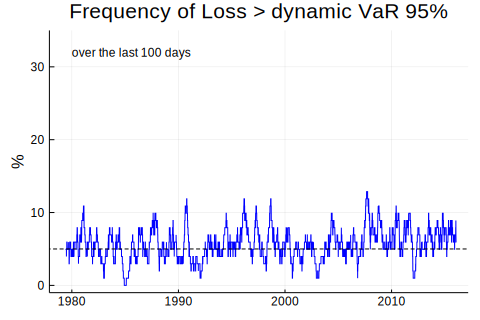

In [11]:
VaR95 = -(μT .- 1.64*sqrt.(s2T))

BreakFreqT = fill(NaN,T)                   #vector, freq(Loss>VaR) on moving data window
for t = 101:T
    BreakFreqT[t] = mean(Loss[t-100:t] .> VaR95[t-100:t])
end

xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]

plot( dN,BreakFreqT*100,
      linecolor = :blue,
      ylim = (-1,35),
      legend = false,
      xticks = (xTicksLoc,xTicksLab),
      title = "Frequency of Loss > dynamic VaR 95%",
      ylabel= "%",
      annotation = (Dates.value(Date(1980)),32,text("over the last 100 days",8,:left)) )

hline!([5],linecolor=:black,line=(:dash,1))

# Expected Shortfall

Recall: $\text{ES}_{\alpha}=-\text{E}(R|R\leq-\text{VaR}_{\alpha})$

For a normally distributed return $R\sim N(\mu,\sigma^{2})$ we have

$\text{ES}_{95\%}=-\mu+\frac{\phi(-1.64)}{0.05}\sigma$

In [12]:
μ = 8
σ = 16
ES95 = -μ + ϕ(-1.64)/0.05*σ

printlnPs("N() based ES 95% with μ=$μ and σ=$σ is: ",ES95)

N() based ES 95% with μ=8 and σ=16 is:     25.268


In [13]:
(ESN,ES_emp) = (fill(NaN,L),fill(NaN,L)) 
for i = 1:L
    #local c, vv_i           #only needed in REPL/script
    c         = quantile(Normal(0,1),1-confLev[i])  #critical value
    ESN[i]    = -μ_emp .+ ϕ(c)/(1-confLev[i])*σ_emp
    vv_i      = Loss .> VaR[i]
    ES_emp[i] = mean(Loss[vv_i])        #mean of obs when Loss > VaR
end

printblue("Expected Shortfall:")
colNames = ["conf level","ES from N()","ES (historical)"]
printTable([confLev ESN ES_emp],colNames,fill("",L),width=20)

Expected Shortfall:
          conf level         ES from N()     ES (historical)
               0.950               2.254               2.754
               0.955               2.303               2.859
               0.960               2.356               2.940
               0.965               2.415               3.021
               0.970               2.482               3.102
               0.975               2.560               3.212
               0.980               2.652               3.368
               0.985               2.767               3.574
               0.990               2.924               3.817
               0.995               3.176               4.219

